# Classification. Linear models and KNN

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [4]:
PATH = "./data/"

In [103]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [6]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [152]:
# Helper function
def plot_barchart(index, datas, labels, title, ylabel):
    p1 = plt.bar(index, datas[0], 0.35)
    p2 = plt.bar(index, datas[1], 0.35,
                 bottom=datas[0])

    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(0, 1.1)
    if labels:
        plt.legend((p1[0], p2[0]), labels)

    plt.show()    

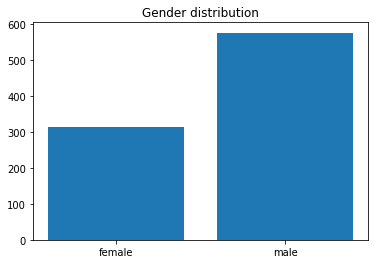

In [76]:
# Genders
genders = data.groupby(['Sex'])['Sex'].count()

plt.bar(genders.index, genders)
plt.title('Gender distribution')
plt.show()

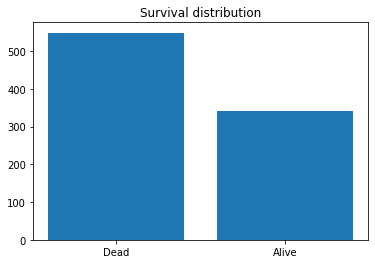

In [77]:
# Genders
survival = data.groupby(['Survived'])['Survived'].count()

plt.bar(['Dead', 'Alive'], survival)
plt.title('Survival distribution')
plt.show()

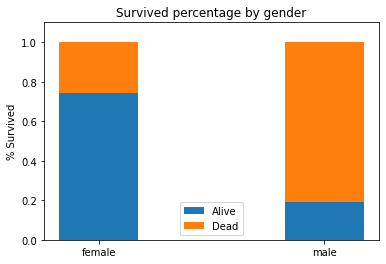

In [147]:
aliveMeans = data[data['Survived'] == 1].groupby(['Sex'])['Sex'].count() / data.groupby(['Sex'])['Survived'].count()
deadMeans = data[data['Survived'] == 0].groupby(['Sex'])['Sex'].count() / data.groupby(['Sex'])['Survived'].count()

plot_barchart(aliveMeans.index, [aliveMeans, deadMeans],('Alive', 'Dead'), 'Survived percentage by gender', '% Survived' )

**Conclusion:** You'd better to be a female to survive on Titanic, probability to stay alive almost 3 time higher than for male.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

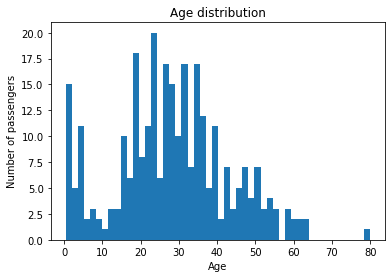

In [175]:
ages = data[(data['Survived'] == 1)]['Age'].dropna()
plt.hist(ages, bins=50)
plt.title('Age distribution')
plt.ylabel('Number of passengers')
plt.xlabel('Age')
plt.show()

In [98]:
# Average age
data[['Age', 'Survived']].dropna().groupby(['Survived']).mean()

,Age
Survived,
0,30.626179
1,28.343690


In [99]:
# Median age
data[['Age', 'Survived']].dropna().groupby(['Survived']).median()

,Age
Survived,
0,28.0
1,28.0


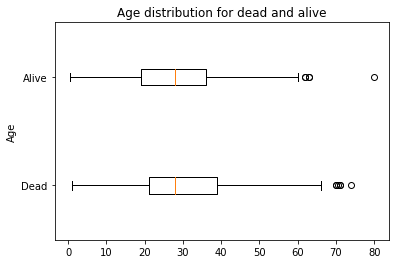

In [134]:
# Age distibution for dead/alive
age_survival = data[['Age', 'Survived']].dropna()

plt.boxplot([age_survival[(age_survival['Survived'] == 0)]['Age'], 
             age_survival[(age_survival['Survived'] == 1)]['Age']], labels=['Dead', 'Alive'], vert=False)

plt.title('Age distribution for dead and alive')
plt.ylabel('Age')
plt.show()

**Thoughts:** Age distibution for dead and alive a little bit different: very old people is likely to decease. Average and median ages are almost the same.
Observation can be easily explained: youngers are faster and theirs health is stronger.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

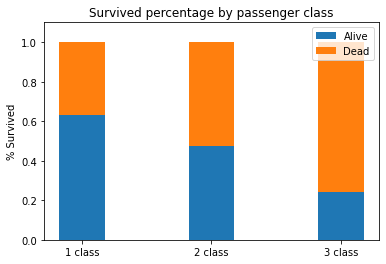

In [164]:
# Passenger class
pclass_enum = sorted([f'{x} class' for x in data['Pclass'].dropna().unique()])

plot_barchart(pclass_enum, [data[data['Survived'] == 1].groupby(['Pclass'])['Pclass'].count() / data.groupby(['Pclass'])['Survived'].count(),
                                                   data[data['Survived'] == 0].groupby(['Pclass'])['Pclass'].count() / data.groupby(['Pclass'])['Survived'].count()],
                                        ('Alive', 'Dead'), 
                                      'Survived percentage by passenger class', '% Survived' )

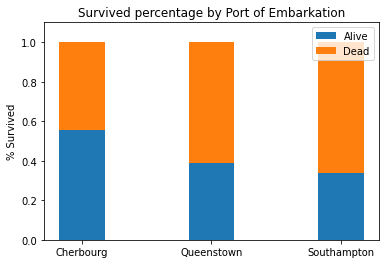

In [166]:
# Embarked
embarked_enum = {'C': 'Cherbourg', 'Q': 'Queenstown', 'S':'Southampton'}
embarked_enum = sorted([embarked_enum[x] for x in data['Embarked'].dropna().unique()])

plot_barchart(embarked_enum, [data[data['Survived'] == 1].groupby(['Embarked'])['Embarked'].count() / data.groupby(['Embarked'])['Survived'].count(),
                                                   data[data['Survived'] == 0].groupby(['Embarked'])['Embarked'].count() / data.groupby(['Embarked'])['Survived'].count()],
                      ('Alive', 'Dead'),
                      'Survived percentage by Port of Embarkation', 
                      '% Survived' )


**Thoughts:** First-class passengers are more likely to survive. Port of embarkation has light influence on survival probability. Cherbourg is a France town, so survival might be related to nationality.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [30]:
data.isnull().mean() * 100

Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

**Thoughts:** 
# NEED TO UPDATE
- For `Embarked` add new value 'NA'
    (`+` - separate calculations for 'unknown' port, `-` - survival probability for real ports might be incorrect)
- For `Cabin` drop feature, because too many missing values 
    (`+` - lower noise in model, `-` - probable missing influence of passenger location)
- For `Age` suggest mean for passengers of the same class.
    (`+` - age is taken into account, `-` - probable incorrect age for passenges)

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [8]:
y = data['Survived']

In [201]:
# Helper function
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

test_data_preprocess = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
whole_data = data.append(test_data_preprocess)

whole_data['FamilyName'] = whole_data['Name'].str.split(',', expand=True)[0]

whole_data['Family'] = whole_data['Parch'] + whole_data['SibSp']

families = whole_data[(whole_data['Parch'] + whole_data['SibSp'] > 0)]['FamilyName'].unique()

data['FamilyName'] = data['Name'].str.split(',', expand=True)[0]

survived_families = data[(data['FamilyName'].isin(families)) & (data['Survived'] == 1)]['FamilyName'].unique()
deceased_families = data[(data['FamilyName'].isin(families)) & (data['Survived'] == 0)]['FamilyName'].unique()

#deceased_families = data[(data['Parch'] + data['SibSp'] > 0)]['FamilyName'].unique()

non_unique_tickets = whole_data.groupby(['Ticket']).filter(lambda x: len(x) > 1)['Ticket'].unique()

non_unique_tickets_survived = data[data['Ticket'].isin(non_unique_tickets) & (data['Survived'] == 1)]['Ticket'].unique()
non_unique_tickets_deceased = data[data['Ticket'].isin(non_unique_tickets) & (data['Survived'] == 0)]['Ticket'].unique()

fare_median = whole_data['Fare'].median()

title_remap = {' Mr': 'Mr', ' Mrs': 'Mrs', ' Miss': 'Miss', ' Master': 'Master', ' Don': 'Mr', ' Rev': 'Rev', ' Dr': 'Mr', ' Mme': 'Mrs',
   ' Ms': 'Miss', ' Major': 'Mr', ' Lady': 'Mrs', ' Sir': 'Mr', ' Mlle': 'Miss', ' Col': 'Mr', ' Capt': 'Mr',
   ' the Countess': 'Mrs', ' Jonkheer': 'Mr', ' Dona': 'Mrs'}
whole_data['Title'] = whole_data['Name'].str.split('[,.]', expand=True)[1].replace(title_remap)
whole_data['NewAge'] = whole_data['Age'].fillna(whole_data.groupby(['Title'])['Age'].transform('median'))
whole_data['FareRange'] = pd.qcut(whole_data['Fare'].fillna(fare_median), 5)
whole_data['TicketCount'] = whole_data.groupby('Ticket')['Ticket'].transform('count')

whole_data['SurvivalPerTicketCount'] = whole_data.groupby('TicketCount')['Survived'].transform('mean')

def transform_data(df):
    df['Family'] = df['Parch'] + df['SibSp']

    df['FamilyName'] = df['Name'].str.split(',', expand=True)[0]
    
    df['FamilySurvival'] = 0.5

    df.loc[df['FamilyName'].isin(survived_families) & (df['FamilySurvival'] == 0.5), 'FamilySurvival'] = 1
    df.loc[df['FamilyName'].isin(deceased_families) & (df['FamilySurvival'] == 0.5), 'FamilySurvival'] = 0

#     df.loc[df['Ticket'].isin(non_unique_tickets_survived) & (df['FamilySurvival'] == 0.5), 'FamilySurvival'] = 1
#     df.loc[df['Ticket'].isin(non_unique_tickets_deceased) & (df['FamilySurvival'] == 0.5), 'FamilySurvival'] = 0

    df = df.join(whole_data[['NewAge', 'FareRange', 'SurvivalPerTicketCount']])

    df['AgeRange'] = pd.qcut(df['NewAge'].dropna(), 4)

 #   df['NewEmbarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    #df['FareRange'] = pd.qcut(df['Fare'].fillna(fare_median), 3)
#    df['FareRange'] = pd.qcut(df['Fare'].fillna(df.groupby(['Pclass'])['Fare'].transform('mean')), 5)
#     df['NewFare'] = df['NewFare'] / df['Family']
#     df['Alone'] = (df['Parch'] + df['SibSp']) == 0
#     df['NewCabin'] = df['Cabin'].dropna().str[0]
#     df['NewCabin'] = LabelEncoder().fit_transform(df['NewCabin'])
#     df['NewCabin'] = df['NewCabin'].fillna(100)
    df['NewSex'] = LabelEncoder().fit_transform(df['Sex'])
    df['FareRange'] = LabelEncoder().fit_transform(df['FareRange'])
    df['AgeRange'] = LabelEncoder().fit_transform(df['AgeRange'])
#    print(pd.get_dummies(df[['AgeRange', 'NewSex', 'Pclass', 'FareRange', 'Family', 'FamilySurvival']]).head())
#     df['NewEmbarked'] = LabelEncoder().fit_transform(df['NewEmbarked'])
#     df['Adult'] = df['NewAge'] >= 18
    std_scaler = StandardScaler()
    
    return std_scaler.fit_transform(pd.get_dummies(df[['NewAge', 'NewSex', 'Pclass', 'FareRange', 'Family', 'FamilySurvival', 'SurvivalPerTicketCount']]))
#    return std_scaler.fit_transform(pd.get_dummies(df[['NewAge', 'NewEmbarked', 'NewSex', 'NewFare']]))
#pd.get_dummies(df[['NewAge', 'Family', 'NewEmbarked', 'Sex', 'NewFare', 'Pclass', 'Alone', 'Cabin']])


Survived                  31.932773
Pclass                     0.000000
Name                       0.000000
Sex                        0.000000
Age                       20.091673
SibSp                      0.000000
Parch                      0.000000
Ticket                     0.000000
Fare                       0.076394
Cabin                     77.463713
Embarked                   0.152788
FamilyName                 0.000000
Family                     0.000000
Title                      0.000000
NewAge                     0.000000
FareRange                  0.000000
TicketCount                0.000000
SurvivalPerTicketCount     0.000000
dtype: float64

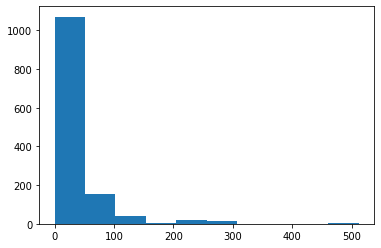

In [200]:
# data['NewAge'] =data['Age']
# data['NewAge'] = data['NewAge'].fillna(data.groupby(['Pclass', 'Sex'])['NewAge'].transform('mean'))
# data['AgeRange'] = pd.cut(data['NewAge'].dropna(), np.arange(0, 100, 5), labels=np.arange(0, 95, 5) + 2.5)

# data['NewEmbarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
# data['NewFare'] = data['Fare'].fillna(0)
# data['Alone'] = (data['Parch'] + data['SibSp']) == 0
# data['Cabin'] = data['Cabin'].fillna('Z').str[0]
# data['Family'] = data['Parch'] + data['SibSp']
# data['NewSex'] = LabelEncoder().fit_transform(data['Sex'])

# pd.get_dummies(data[['NewAge', 'Embarked', 'NewSex', 'NewFare', 'Family', 'Pclass', 'Parch']])
# test_data[(test_data['Age'].isna())]['Name'].str.split(',')

# data['FamilySurvival'] = 0.5
# survived_families = data[(data['Family'] > 1) & (data['FamilySurvival'] == 0.5) & (data['Survived'] == 1)]['FamilyName'].unique()
# data.loc[data['FamilyName'].isin(survived_families), 'FamilySurvival'] = 1
# deceased_families = data[(data['Family'] > 1) & (data['FamilySurvival'] == 0.5) & (data['Survived'] == 0)]['FamilyName'].unique()
# data.loc[data['FamilyName'].isin(deceased_families), 'FamilySurvival'] = 0

#test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))
#test_data['Name'].str.split('[,.]', expand=True)[1].unique()
#whole_data
#transform_data(data.copy())
plt.hist(whole_data['Fare'])
whole_data['Fare'].describe()
whole_data.isnull().mean() * 100

In [202]:
X_train = transform_data(data.copy())

log_model = LogisticRegression(solver='liblinear', penalty='l1')
knn_model = KNeighborsClassifier()

log_model.fit(X=X_train, y=y)
knn_model.fit(X=X_train, y=y)

print( f'LogisticRegression model accuracy: {accuracy_score(y, log_model.predict(X_train))}')
print( f'KNeighborsClassifier model accuracy: {accuracy_score(y, knn_model.predict(X_train))}')

print( f'LogisticRegression model cross validate score (mean): {cross_validate(log_model, X_train, y, cv=5)["test_score"].mean()}')
print( f'KNeighborsClassifier model cross validate score (mean): {cross_validate(knn_model, X_train, y, cv=5)["test_score"].mean()}')


LogisticRegression model accuracy: 0.8428731762065096
KNeighborsClassifier model accuracy: 0.8765432098765432
LogisticRegression model cross validate score (mean): 0.840631473228297
KNeighborsClassifier model cross validate score (mean): 0.8540957880861214


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [203]:
X_train = transform_data(data.copy())
res_max = 0
for neighb in np.arange(1, 30):
    for algo in['auto', 'ball_tree', 'kd_tree', 'brute']:
        for w in ['uniform', 'distance']:
            for leaf in np.arange(28, 31):
    #knn_model_upgrade = LogisticRegression(solver='newton-cg', penalty='l2')
                knn_model_upgrade = KNeighborsClassifier(n_neighbors=neighb, weights=w, algorithm=algo, leaf_size=leaf)
                res = cross_validate(knn_model_upgrade, X_train, y, cv=5)["test_score"].mean()
                if res_max < res:
                    res_max = res
                    params = (neighb, algo, w, leaf)
print(f'{params}: {res_max}')

# knn_model_upgrade = LogisticRegression(solver='newton-cg', penalty='l2')
# cross_validate(knn_model_upgrade, X_train, y, cv=5)["test_score"].mean()

# knn_model_upgrade = KNeighborsClassifier(n_neighbors=6, weights='distance')
# knn_model_upgrade.fit(X_train, y)
# plot_confusion_matrix(knn_model_upgrade, X_train, y,
#                              cmap=plt.cm.Blues,
#                              normalize=None)

(8, 'brute', 'uniform', 28): 0.8608624693992845


Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [204]:
X_train = transform_data(data.copy())

knn_model_upgradeD = KNeighborsClassifier(n_neighbors=8, weights='uniform', algorithm='brute',leaf_size=28)
#knn_model_upgradeD = LogisticRegression(solver='newton-cg', penalty='l2', random_state=13)# 
knn_model_upgradeD.fit(X_train, y)

test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))


X_test = transform_data(test_data.copy().set_index('PassengerId'))
y_pred = knn_model_upgradeD.predict(X_test)

output_titanic = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': y_pred})
output_titanic.to_csv('titanic_KNN_8_brute_uniform_0860.csv', index=False)

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [14]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [15]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [16]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [17]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [20]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

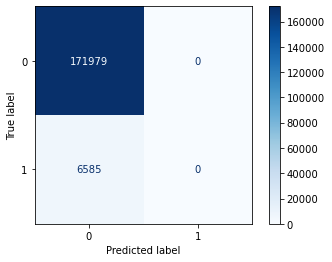

In [21]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [22]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

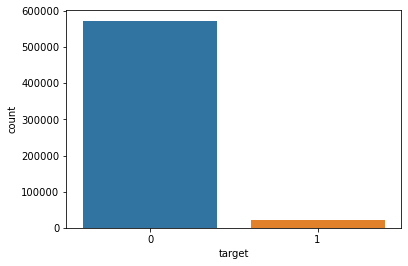

In [23]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [24]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [25]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [26]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [27]:
## your code

In [ ]:
#0.76
def transform_data(df):
    df['NewAge'] = df['Age']
    df['NewAge'] = df['NewAge'].fillna(data.groupby(['Sex', 'Pclass'])['NewAge'].transform('median'))
    df['AgeRange'] = pd.cut(df['NewAge'].dropna(), np.arange(0, 100, 15))

    df['NewEmbarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    df['NewFare'] = df['Fare'].fillna(data.groupby(['Pclass'])['Fare'].transform('mean'))
    df['Family'] = df['Parch'] + df['SibSp'] + 1
    df['NewFare'] = df['NewFare'] / df['Family']
    df['Alone'] = (df['Parch'] + df['SibSp']) == 0
    df['Cabin'] = df['Cabin'].fillna('Z').str[0]
    df['NewSex'] = LabelEncoder().fit_transform(df['Sex'])
    df['NewEmbarked'] = LabelEncoder().fit_transform(df['NewEmbarked'])
    df['Adult'] = df['NewAge'] >= 18
    std_scaler = StandardScaler()
    
    return std_scaler.fit_transform(pd.get_dummies(df[['AgeRange', 'Embarked', 'NewSex', 'NewFare', 'Family', 'Pclass']]))
#    return std_scaler.fit_transform(pd.get_dummies(df[['NewAge', 'NewEmbarked', 'NewSex', 'NewFare']]))
#pd.get_dummies(df[['NewAge', 'Family', 'NewEmbarked', 'Sex', 'NewFare', 'Pclass', 'Alone', 'Cabin']])


knn_model_upgradeD = KNeighborsClassifier(n_neighbors=6, weights='distance')
#knn_model_upgradeD = LogisticRegression(solver='newton-cg', penalty='l2', random_state=13)# 
knn_model_upgradeD.fit(X_train, y)

test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))


X_test = transform_data(test_data)
y_pred = knn_model_upgradeD.predict(X_test)

output_titanic = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': y_pred})
output_titanic.to_csv('titanic_KNN_6_D.csv', index=False)